<a href="https://colab.research.google.com/github/Kondwani7/Zebra_elephant_classifier/blob/main/Zebra_Elephant_Classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [2]:
import keras
import tensorflow as tf
#data preparation visualisation and hyper tuning tools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import cv2
from tqdm import tqdm

In [4]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("/content/drive/MyDrive/sampleAnimalDataset"))



['sample_train', 'sample_test', 'sample_submission.csv%3Fsp=r&sv=2015-04-05&sr=b&st=2021-02-21T11%3A37%3A20Z&se=2021-02-21T11%3A53%3A20Z&sig=ygxK8o%2F9ZnSiz3DKXWYbPV8o%2F5yJze4alG7H9bu97cs=.csv']


In [5]:
train = '/content/drive/MyDrive/Animal Classifier/train'
test = '/content/drive/MyDrive/Animal Classifier/test'
train_elephants = '/content/drive/MyDrive/Animal Classifier/train/train_elephants'
train_zebras = '/content/drive/MyDrive/Animal Classifier/train/train_zebras'

test_elephants = '/content/drive/MyDrive/Animal Classifier/test/test_elephants'
test_zebras = '/content/drive/MyDrive/Animal Classifier/test/test_zebras'



In [7]:
filenames = os.listdir(train)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'train_elephants':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [8]:
df.describe

<bound method NDFrame.describe of     filename  category
0  elephants         0
1     zebras         0>

In [9]:
df.head(100)

,filename,category
0,elephants,0
1,zebras,0


In [ ]:
df.tail()

,filename,category
0,train_elephants,1
1,train_zebras,0


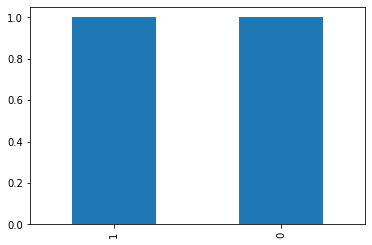

In [ ]:
df['category'].value_counts().plot.bar()

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

In [12]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
IMAGE_SIZE = 224 # 224 for MobileNetV2
BATCH_SIZE = 64
base_dir = '/content/drive/MyDrive/Animal Classifier/train'

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.05,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

Found 3084 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


In [14]:
# Print data shapes
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

In [15]:
print(train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('/content/drive/MyDrive/Animal Classifier/labels.txt', 'w') as f:
    f.write(labels) 



{'elephants': 0, 'zebras': 1}


In [16]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model Inception V3
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
base_model.trainable = False

In [18]:
for layer in base_model.layers:
    layer.trainable = True

In [23]:
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2, activation='softmax')
])



In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 32)          368672    
                                                                 
 dropout_9 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 dropout_10 (Dropout)        (None, 3, 3, 64)          0         
                                                                 
 conv2d_12 (Conv2D)          (None, 1, 1, 128)         73856     
                                                        

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [28]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 8


In [30]:
epochs = 6


history = model.fit(train_generator,
                      epochs=epochs,
                      validation_data=val_generator)


Epoch 1/6
49/49 [==============================] - 277s 6s/step - loss: 0.0687 - accuracy: 0.9809 - val_loss: 0.4710 - val_accuracy: 0.8416
Epoch 2/6
49/49 [==============================] - 263s 5s/step - loss: 0.0572 - accuracy: 0.9799 - val_loss: 0.4633 - val_accuracy: 0.8351
Epoch 3/6
49/49 [==============================] - 254s 5s/step - loss: 0.0511 - accuracy: 0.9848 - val_loss: 0.4147 - val_accuracy: 0.8987
Epoch 4/6
49/49 [==============================] - 251s 5s/step - loss: 0.0538 - accuracy: 0.9854 - val_loss: 0.4449 - val_accuracy: 0.8740
Epoch 5/6
49/49 [==============================] - 253s 5s/step - loss: 0.0458 - accuracy: 0.9831 - val_loss: 0.4343 - val_accuracy: 0.8519
Epoch 6/6
49/49 [==============================] - 258s 5s/step - loss: 0.0470 - accuracy: 0.9854 - val_loss: 0.4310 - val_accuracy: 0.8701


#Plot model performance

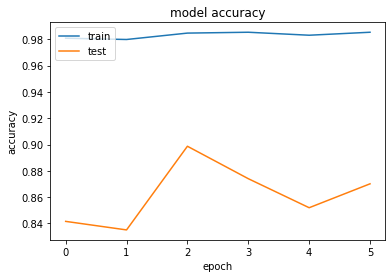

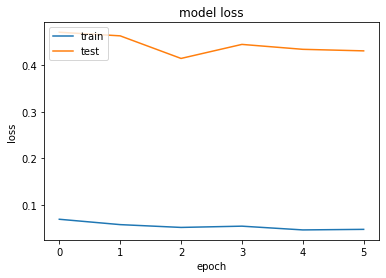

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
base_model.trainable = True

In [45]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-7),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 32)          368672    
                                                                 
 dropout_9 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 dropout_10 (Dropout)        (None, 3, 3, 64)          0         
                                                                 
 conv2d_12 (Conv2D)          (None, 1, 1, 128)         73856     
                                                        

In [48]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 62


In [49]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

batch_size = 64

In [50]:
epochs = 7


history = model.fit(train_generator, 
                        epochs=epochs,
                        validation_data=val_generator,
                        callbacks=[learning_rate_reduction])


Epoch 1/7
49/49 [==============================] - 261s 5s/step - loss: 0.0947 - accuracy: 0.9698 - val_loss: 0.4000 - val_accuracy: 0.8766 - lr: 1.0000e-07
Epoch 2/7
49/49 [==============================] - 249s 5s/step - loss: 0.0849 - accuracy: 0.9760 - val_loss: 0.4476 - val_accuracy: 0.8649 - lr: 1.0000e-07
Epoch 3/7
49/49 [==============================] - 253s 5s/step - loss: 0.0922 - accuracy: 0.9724 - val_loss: 0.4442 - val_accuracy: 0.8883 - lr: 1.0000e-07
Epoch 4/7
49/49 [==============================] - 253s 5s/step - loss: 0.0857 - accuracy: 0.9754 - val_loss: 0.4826 - val_accuracy: 0.8753 - lr: 1.0000e-07
Epoch 5/7
49/49 [==============================] - 252s 5s/step - loss: 0.0620 - accuracy: 0.9825 - val_loss: 0.3989 - val_accuracy: 0.8909 - lr: 1.0000e-07
Epoch 6/7
49/49 [==============================] - 249s 5s/step - loss: 0.0743 - accuracy: 0.9767 - val_loss: 0.4281 - val_accuracy: 0.8831 - lr: 1.0000e-07
Epoch 7/7
49/49 [==============================] - 246s 5s

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import keras
from tensorflow.keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 

In [ ]:
train = '/content/drive/MyDrive/sampleAnimalDataset/sample_train'
test = '/content/drive/MyDrive/sampleAnimalDataset/sample_train'
train_elephants = '/content/drive/MyDrive/sampleAnimalDataset/sample_train/sample_train_elephants'
train_zebras = '/content/drive/MyDrive/sampleAnimalDataset/sample_train/sample_train_zebras'

test_elephants = '/content/drive/MyDrive/sampleAnimalDataset/sample_test/sample_test_elephants'
test_zebras = '/content/drive/MyDrive/sampleAnimalDataset/sample_test/sample_test_zebras'

input_shape = (224,224,3)

In [ ]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

batch_size = 64

NameError: ignored